In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

In [4]:
# load samples list and genotypes matrix
samples = np.load('data/samples.npy')
genotypes = np.load('data/chr1_genotypes6468094.npz')
genotypes = genotypes['arr_0']

print('Number of samples:', len(samples))
print('Genotypes matrix shape:', genotypes.shape)

Number of samples: 2504
Genotypes matrix shape: (2504, 6468094)


In [16]:
# key = sample_id, value = [population, super_population, gender]
with open('data/sample_info.pkl', 'rb') as file:
    sample_info = pickle.load(file)

# key = superpopulation, value = associated color
with open('data/superpopulation_colors.pkl', 'rb') as file:
    superpopulation_colors = pickle.load(file)

# key = subpopulation, value = associated color
with open('data/subpopulation_colors.pkl', 'rb') as file:
    subpopulation_colors = pickle.load(file)

subpopulations = [sample_info[sample_id][0] for sample_id in samples]
superpopulations = [sample_info[sample_id][1] for sample_id in samples]

In [6]:
# perform PCA on the genotypes matrix
pca = PCA(n_components=2)
pca_result = pca.fit_transform(genotypes)

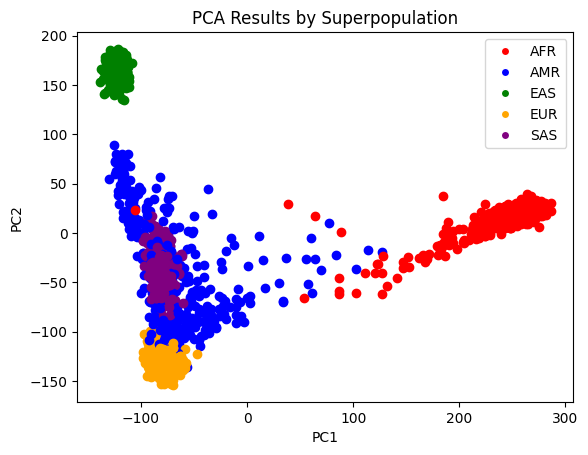

In [12]:
# extract PCA data points and superpopulations
data_points = pca_result[:, :2]  # Take the first two principal components

# create scatter plot
for data, superpop in zip(data_points, superpopulations):
    color = superpopulation_colors.get(superpop, 'gray')  # Use gray color for unknown superpopulations
    plt.scatter(data[0], data[1], color=color)

plt.title('PCA Results by Superpopulation')
plt.xlabel('PC1')
plt.ylabel('PC2')

# add superpopulation legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=superpop, markerfacecolor=color)
                   for superpop, color in superpopulation_colors.items()]
plt.legend(handles=legend_elements)

plt.savefig(f"results/pca_superpopulations{genotypes.shape[1]}")
plt.show()

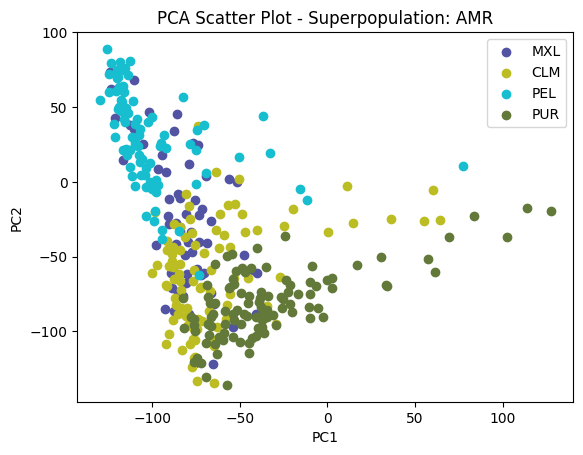

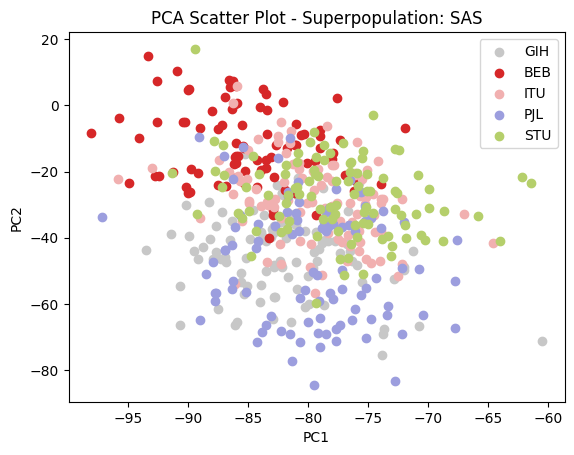

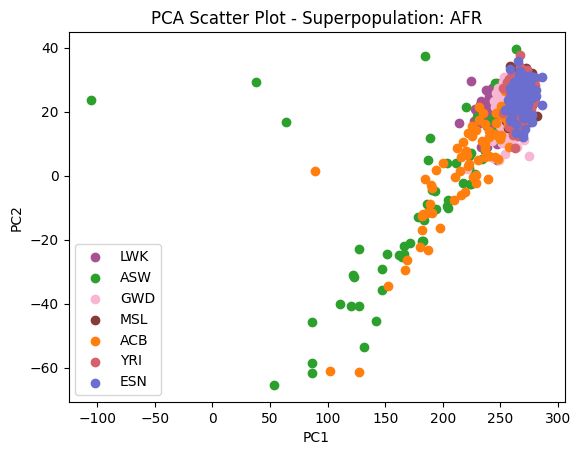

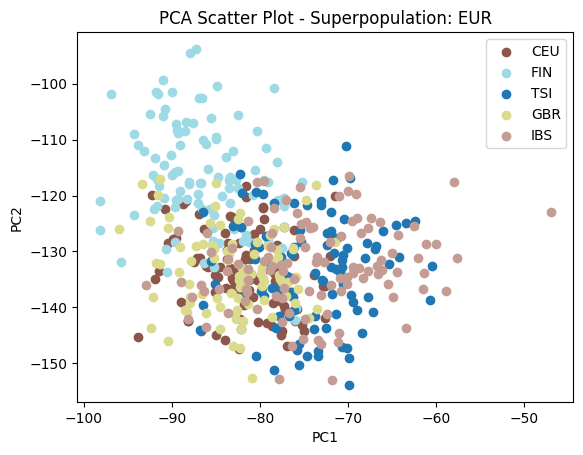

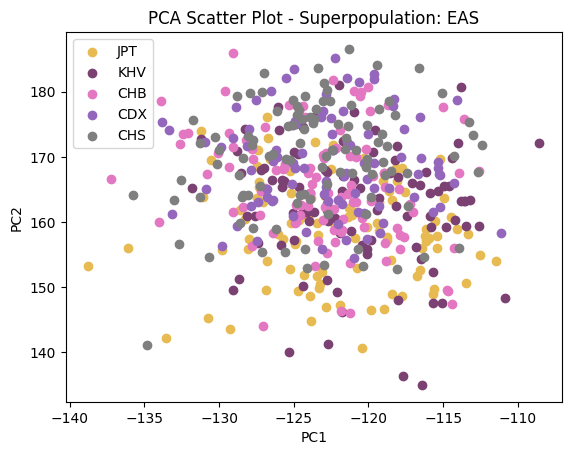

In [17]:
# get unique superpopulations
unique_superpopulations = list(set(superpopulations))

# Perform PCA for each superpopulation
for superpop in unique_superpopulations:
    # Filter genotypes matrix and sample info for the current superpopulation
    superpop_samples = [sample_id for sample_id in samples if sample_info[sample_id][1] == superpop]

    # Extract PCA data points and subpopulations
    data_points = pca_result[:, :2]  # Take the first two principal components
    unique_subpopulations = [sample_info.get(sample_id, [None, None, None])[0] for sample_id in superpop_samples]  # Extract subpopulations

    # Create scatter plot for the current superpopulation
    plt.figure()
    for subpop in set(unique_subpopulations):
        # Filter data points for the current subpopulation
        subpop_data_points = [data for data, subpop_label in zip(data_points, subpopulations) if subpop_label == subpop]
        color = subpopulation_colors.get(subpop, 'gray')  # Use gray color for unknown subpopulations
        plt.scatter(*zip(*subpop_data_points), color=color, label=subpop)

    plt.title(f'PCA Scatter Plot - Superpopulation: {superpop}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # Add subpopulation legend
    plt.legend()

    plt.show()

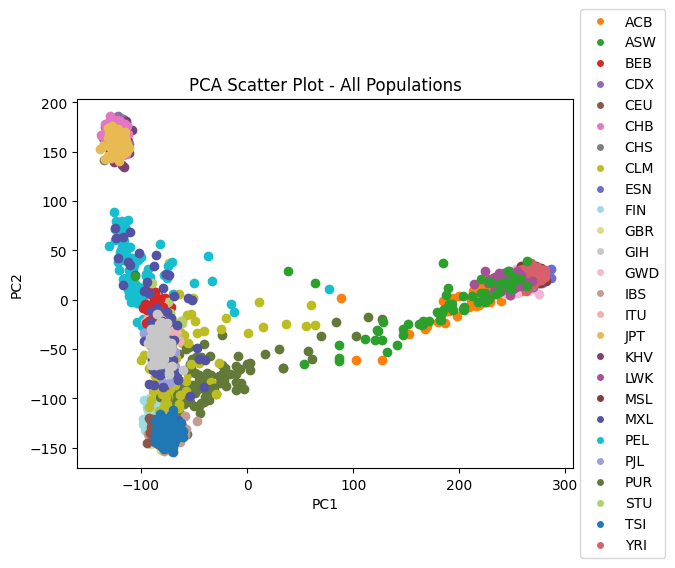

In [18]:
# get unique populations
unique_populations = list(set(subpopulations))

# create a scatter plot
for data, pop in zip(pca_result[:, :2], subpopulations):
    color = subpopulation_colors.get(pop, 'gray')  # Use gray color for unknown populations
    plt.scatter(data[0], data[1], color=color)

plt.title('PCA Scatter Plot - All Populations')
plt.xlabel('PC1')
plt.ylabel('PC2')

# create population legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=pop, markerfacecolor=color)
                   for pop, color in subpopulation_colors.items() if pop in unique_populations]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()